# 02 - Data Preprocessing & Feature Engineering

## What is Preprocessing?

**Preprocessing** = Preparing raw data before feeding it to ML models.

Think of it like cooking:
- Raw data = raw ingredients (unwashed vegetables, uncut meat)
- Preprocessing = washing, cutting, seasoning
- ML model = the oven
- You can't put raw ingredients directly in the oven and expect good results!

## What is Feature Engineering?

**Feature** = A measurable property of your data that the model uses to learn.

**Feature Engineering** = Creating NEW useful properties from existing data.

Example:
- Raw data: `close = 86626.39` (BTC price)
- Engineered feature: `return = 0.15%` (price changed by 0.15% from last hour)

**Why engineer features?**
- Raw price ($86,626) is meaningless alone - is that high? low? 
- But "0.15% change" is meaningful - we can compare it to other hours
- ML models learn patterns better from relative/normalized data

In [1]:
# ============================================
# STEP 1: IMPORT LIBRARIES
# ============================================

# pandas: For working with tables (DataFrames)
# Think of it like Excel in Python
import pandas as pd

# numpy: For mathematical operations on arrays
# Much faster than regular Python math
import numpy as np

# matplotlib: For creating charts/plots
import matplotlib.pyplot as plt

# Display settings - show all columns when we print
pd.set_option('display.max_columns', None)

print("Libraries loaded successfully!")

Libraries loaded successfully!


## Step 1: Load the Data

In [2]:
# ============================================
# STEP 2: LOAD DATA FROM CSV FILES
# ============================================

# pd.read_csv() reads a CSV file into a DataFrame
# Adjust the path based on where your files are!

btc = pd.read_csv('../data/raw/BTCUSDT_1h.csv')
eth = pd.read_csv('../data/raw/ETHUSDT_1h.csv')

# .shape tells us (rows, columns)
print(f"BTC data: {btc.shape[0]} rows, {btc.shape[1]} columns")
print(f"ETH data: {eth.shape[0]} rows, {eth.shape[1]} columns")

BTC data: 1000 rows, 6 columns
ETH data: 1000 rows, 6 columns


In [3]:
# Look at first 5 rows
# .head() shows the first N rows (default 5)
btc.head()

,timestamp,open,high,low,close,volume
0,2025-12-17 05:00:00,86752.27,86756.74,86209.11,86626.39,634.29318
1,2025-12-17 06:00:00,86626.40,87005.27,86587.82,86777.98,454.66393
2,2025-12-17 07:00:00,86777.98,87169.37,86593.55,87045.59,627.05868
3,2025-12-17 08:00:00,87045.59,87045.59,86326.80,86395.66,456.87442
4,2025-12-17 09:00:00,86395.67,86615.38,86262.85,86417.46,334.04163


In [4]:
# Check data types of each column
# This is important because:
# - Numbers should be int64 or float64
# - Dates should be datetime64
# - Text should be object

print("Data types:")
print(btc.dtypes)

Data types:
timestamp     object
open         float64
high         float64
low          float64
close        float64
volume       float64
dtype: object


## Step 2: Check for Missing Values

### What are Missing Values?

**Missing value** = A cell in your data that has no value (empty).

In pandas, missing values are shown as `NaN` (Not a Number).

**Why do missing values happen?**
- Sensor malfunction
- Data not collected
- Exchange was down
- Error during download

**Why are they a problem?**
- Most ML models crash when they see NaN
- Calculations like mean() ignore NaN, which can skew results
- We need to either remove or fill them

In [5]:
# ============================================
# CHECK FOR MISSING VALUES
# ============================================

# .isnull() returns True/False for each cell (True = missing)
# .sum() counts the True values

print("=== BTC Missing Values ===")
print(btc.isnull().sum())
print(f"\nTotal missing cells: {btc.isnull().sum().sum()}")

print("\n=== ETH Missing Values ===")
print(eth.isnull().sum())
print(f"\nTotal missing cells: {eth.isnull().sum().sum()}")

=== BTC Missing Values ===
timestamp    0
open         0
high         0
low          0
close        0
volume       0
dtype: int64

Total missing cells: 0

=== ETH Missing Values ===
timestamp    0
open         0
high         0
low          0
close        0
volume       0
dtype: int64

Total missing cells: 0


### How to Handle Missing Values (if we had any)

There are 3 main strategies:

| Strategy | Code | When to use |
|----------|------|-------------|
| **Delete rows** | `df.dropna()` | When you have lots of data and few missing rows |
| **Fill with previous value** | `df.fillna(method='ffill')` | Good for time series (price stays same until next update) |
| **Fill with average** | `df['col'].fillna(df['col'].mean())` | When order doesn't matter |

For financial time series, **forward fill** is usually best because:
- If we don't have a new price, the old price is still valid
- Deleting rows creates gaps in our timeline

In [6]:
# Example (we don't need this if data is complete, but good to know)

# If we had missing values, we would do:
# btc = btc.fillna(method='ffill')  # Forward fill

# Or to delete rows with any missing value:
# btc = btc.dropna()

print("No missing values found - we can proceed!")

No missing values found - we can proceed!


## Step 3: Convert Timestamp to Datetime

### What is a Datetime object?

Right now, our `timestamp` column is just text (a "string"):
- `"2025-12-17 05:00:00"` - Python sees this as letters, not a date

We need to convert it to a **datetime** object so Python understands it's a date/time:
- Can extract year, month, day, hour
- Can calculate differences between dates
- Charts will show proper date axes

In [7]:
# Check current type of timestamp
print("Current type:", type(btc['timestamp'].iloc[0]))
print("Sample value:", btc['timestamp'].iloc[0])

Current type: <class 'str'>
Sample value: 2025-12-17 05:00:00


In [8]:
# ============================================
# CONVERT TIMESTAMP TO DATETIME
# ============================================

# pd.to_datetime() converts strings to datetime objects
btc['timestamp'] = pd.to_datetime(btc['timestamp'])
eth['timestamp'] = pd.to_datetime(eth['timestamp'])

print("After conversion:")
print("Type:", type(btc['timestamp'].iloc[0]))
print("Sample value:", btc['timestamp'].iloc[0])

After conversion:
Type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Sample value: 2025-12-17 05:00:00


In [9]:
# Now we can easily get info from the datetime
print("Data date range:")
print(f"  Start: {btc['timestamp'].min()}")
print(f"  End:   {btc['timestamp'].max()}")
print(f"  Total days: {(btc['timestamp'].max() - btc['timestamp'].min()).days}")

Data date range:
  Start: 2025-12-17 05:00:00
  End:   2026-01-27 20:00:00
  Total days: 41


## Step 4: Feature Engineering

Now the important part! We'll create new features that help detect anomalies.

### Why can't we use raw prices?

**Problem:** BTC price changes over time:
- 2015: BTC = $200
- 2021: BTC = $60,000
- 2024: BTC = $90,000

A $1000 price move:
- In 2015: That's 500% of the price! HUGE anomaly!
- In 2024: That's 1.1% of the price. Pretty normal.

**Solution:** Use **relative** features (percentages) instead of absolute values.

---

### Features We'll Create:

| Feature | What it measures | Why useful for anomaly detection |
|---------|------------------|----------------------------------|
| **Return** | % price change from last hour | Detects sudden price jumps |
| **Log Return** | Same but with logarithm | Better statistical properties |
| **Volatility** | How wildly price moves | Detects unstable periods |
| **Volume Change** | % change in trading volume | Detects unusual trading activity |
| **Volume Ratio** | Current volume vs average | Detects volume spikes |
| **Price Range** | High-Low as % of price | Detects volatile candles |

### Feature 1: Return (Price Change %)

**What is it?**
How much the price changed from the previous hour, as a percentage.

**Formula:**
```
return = (current_price - previous_price) / previous_price × 100
```

**Example:**
- Previous close: $86,626
- Current close: $86,778
- Return = (86778 - 86626) / 86626 × 100 = **0.175%**

**Why useful?**
- Normal hours: return is between -1% and +1%
- Anomaly: return is -5% or +5% (something big happened!)

In [10]:
# ============================================
# FEATURE 1: RETURN (PERCENTAGE PRICE CHANGE)
# ============================================

# .pct_change() calculates percentage change from previous row
# Multiply by 100 to get percentage (0.01 -> 1%)

btc['return'] = btc['close'].pct_change() * 100
eth['return'] = eth['close'].pct_change() * 100

# Let's verify with manual calculation
print("Verify return calculation:")
print(f"Row 0 close: {btc['close'].iloc[0]}")
print(f"Row 1 close: {btc['close'].iloc[1]}")
manual_return = (btc['close'].iloc[1] - btc['close'].iloc[0]) / btc['close'].iloc[0] * 100
print(f"Manual calculation: {manual_return:.4f}%")
print(f"pct_change result: {btc['return'].iloc[1]:.4f}%")

Verify return calculation:
Row 0 close: 86626.39
Row 1 close: 86777.98
Manual calculation: 0.1750%
pct_change result: 0.1750%


In [11]:
# Look at the return distribution
print("BTC Return Statistics:")
print(btc['return'].describe())

BTC Return Statistics:
count    999.000000
mean       0.003544
std        0.390838
min       -2.974525
25%       -0.150462
50%        0.001678
75%        0.158705
max        2.333046
Name: return, dtype: float64


### Feature 2: Log Return

**What is it?**
Same as return, but using natural logarithm.

**Formula:**
```
log_return = ln(current_price / previous_price) × 100
```

**Why use log instead of regular return?**

1. **Additive property**: Log returns can be added across time periods
   - Regular: If day1 = +10% and day2 = -10%, total ≠ 0% (it's -1%)
   - Log: If day1 = +10% and day2 = -10%, total = 0% exactly

2. **More symmetric**: Regular returns are bounded at -100% (can't lose more than everything) but unbounded above. Log returns are symmetric.

3. **Better for statistics**: Log returns are closer to normal distribution.

**For small changes (<5%), regular and log returns are almost identical.**

In [12]:
# ============================================
# FEATURE 2: LOG RETURN
# ============================================

# np.log() is natural logarithm
# .shift(1) gets the previous row's value

btc['log_return'] = np.log(btc['close'] / btc['close'].shift(1)) * 100
eth['log_return'] = np.log(eth['close'] / eth['close'].shift(1)) * 100

# Compare regular vs log return
print("Regular return vs Log return (first 10 rows):")
print(btc[['close', 'return', 'log_return']].head(10))

Regular return vs Log return (first 10 rows):
      close    return  log_return
0  86626.39       NaN         NaN
1  86777.98  0.174993    0.174840
2  87045.59  0.308385    0.307910
3  86395.66 -0.746655   -0.749456
4  86417.46  0.025233    0.025230
5  86624.49  0.239570    0.239283
6  86983.26  0.414167    0.413312
7  87029.55  0.053217    0.053203
8  87631.37  0.691512    0.689132
9  89675.85  2.333046    2.306246


### Feature 3: Volatility (Rolling Standard Deviation)

**What is Volatility?**
How much the returns vary/fluctuate over a period of time.

**What is Rolling?**
"Rolling" means we calculate over a moving window:
- For row 24: calculate using rows 1-24
- For row 25: calculate using rows 2-25
- For row 26: calculate using rows 3-26
- ...and so on

It's like a sliding window that moves through your data.

**What is Standard Deviation (std)?**
Measures how spread out numbers are from their average.
- Low std = numbers are close together (stable)
- High std = numbers are spread out (volatile)

**Formula:**
```
volatility_24h = std(last 24 returns)
```

**Why useful?**
- Normal times: volatility is low (0.3-0.5%)
- Crisis/anomaly: volatility spikes (1-3%)

In [13]:
# ============================================
# FEATURE 3: VOLATILITY (ROLLING STD OF RETURNS)
# ============================================

# .rolling(window=24) creates a 24-hour rolling window
# .std() calculates standard deviation of that window

btc['volatility_24h'] = btc['return'].rolling(window=24).std()
eth['volatility_24h'] = eth['return'].rolling(window=24).std()

# Note: First 23 rows will be NaN (not enough data for 24-hour window)
print("Volatility (first 30 rows):")
print(btc[['timestamp', 'return', 'volatility_24h']].head(30))

Volatility (first 30 rows):
             timestamp    return  volatility_24h
0  2025-12-17 05:00:00       NaN             NaN
1  2025-12-17 06:00:00  0.174993             NaN
2  2025-12-17 07:00:00  0.308385             NaN
3  2025-12-17 08:00:00 -0.746655             NaN
4  2025-12-17 09:00:00  0.025233             NaN
5  2025-12-17 10:00:00  0.239570             NaN
6  2025-12-17 11:00:00  0.414167             NaN
7  2025-12-17 12:00:00  0.053217             NaN
8  2025-12-17 13:00:00  0.691512             NaN
9  2025-12-17 14:00:00  2.333046             NaN
10 2025-12-17 15:00:00 -2.723598             NaN
11 2025-12-17 16:00:00 -0.283068             NaN
12 2025-12-17 17:00:00 -0.643077             NaN
13 2025-12-17 18:00:00 -0.691797             NaN
14 2025-12-17 19:00:00  0.220566             NaN
15 2025-12-17 20:00:00 -0.148049             NaN
16 2025-12-17 21:00:00  0.106763             NaN
17 2025-12-17 22:00:00  0.414280             NaN
18 2025-12-17 23:00:00 -0.111039         

**Notice:** The first 23 rows have `NaN` for volatility. This is because we need 24 values to calculate a 24-hour standard deviation. We'll handle these NaN values later.

### Feature 4: Volume Change

**What is Volume?**
The number of BTC traded in that hour.

**What is Volume Change?**
How much the volume changed from the previous hour, as a percentage.

**Why useful?**
Sudden volume spikes often indicate something unusual:
- Big news announcement
- Whale (large trader) activity
- Market manipulation
- Panic buying/selling

In [14]:
# ============================================
# FEATURE 4: VOLUME CHANGE (%)
# ============================================

btc['volume_change'] = btc['volume'].pct_change() * 100
eth['volume_change'] = eth['volume'].pct_change() * 100

print("Volume change statistics:")
print(btc['volume_change'].describe())

Volume change statistics:
count     999.000000
mean       20.674307
std        92.557075
min       -79.702367
25%       -33.066384
50%        -3.367142
75%        36.188881
max      1113.137577
Name: volume_change, dtype: float64


### Feature 5: Volume Ratio (vs 24h Average)

**What is it?**
Current volume divided by the average volume of the last 24 hours.

**Formula:**
```
volume_ratio = current_volume / average(last 24 hours volume)
```

**Interpretation:**
- volume_ratio = 1.0 -> Normal volume (same as average)
- volume_ratio = 2.0 -> Double the normal volume
- volume_ratio = 0.5 -> Half the normal volume
- volume_ratio = 5.0 -> 5x normal volume (ANOMALY!)

In [15]:
# ============================================
# FEATURE 5: VOLUME RATIO
# ============================================

# .rolling(window=24).mean() calculates the 24-hour moving average
btc['volume_ratio'] = btc['volume'] / btc['volume'].rolling(window=24).mean()
eth['volume_ratio'] = eth['volume'] / eth['volume'].rolling(window=24).mean()

print("Volume ratio statistics:")
print(btc['volume_ratio'].describe())

Volume ratio statistics:
count    977.000000
mean       1.046051
std        0.902717
min        0.126724
25%        0.478034
50%        0.760989
75%        1.265286
max        9.263490
Name: volume_ratio, dtype: float64


### Feature 6: Price Range

**What is it?**
The difference between the highest and lowest price in that hour, as a percentage of the close price.

**Formula:**
```
price_range = (high - low) / close × 100
```

**Why useful?**
- Normal hour: price_range is 0.2-0.5% (price stays stable)
- Volatile hour: price_range is 2-5% (price swings wildly)
- This captures intra-hour volatility that returns might miss

In [16]:
# ============================================
# FEATURE 6: PRICE RANGE
# ============================================

btc['price_range'] = (btc['high'] - btc['low']) / btc['close'] * 100
eth['price_range'] = (eth['high'] - eth['low']) / eth['close'] * 100

print("Price range statistics:")
print(btc['price_range'].describe())

Price range statistics:
count    1000.000000
mean        0.507719
std         0.415282
min         0.052052
25%         0.243728
50%         0.388107
75%         0.633693
max         3.701425
Name: price_range, dtype: float64


## Step 5: Handle NaN Values from Feature Engineering

**Problem:** Some of our new features have NaN values:
- `return`: Row 0 is NaN (can't calculate change from nothing)
- `volatility_24h`: Rows 0-23 are NaN (need 24 rows to calculate)
- `volume_ratio`: Rows 0-23 are NaN (same reason)

**Solution:** Drop the first 24 rows.

**Why is this okay?**
- We have 1000 rows
- Losing 24 rows = 2.4% of data
- Better than having incomplete data that breaks ML models

In [17]:
# Check how many NaN values we have
print("NaN count per column BEFORE cleaning:")
print(btc.isnull().sum())

NaN count per column BEFORE cleaning:
timestamp          0
open               0
high               0
low                0
close              0
volume             0
return             1
log_return         1
volatility_24h    24
volume_change      1
volume_ratio      23
price_range        0
dtype: int64


In [18]:
# ============================================
# DROP ROWS WITH NaN VALUES
# ============================================

rows_before = len(btc)

# dropna() removes any row that has at least one NaN
btc = btc.dropna()
eth = eth.dropna()

rows_after = len(btc)

print(f"Rows before: {rows_before}")
print(f"Rows after:  {rows_after}")
print(f"Rows removed: {rows_before - rows_after} ({(rows_before - rows_after) / rows_before * 100:.1f}%)")

Rows before: 1000
Rows after:  976
Rows removed: 24 (2.4%)


In [19]:
# Verify no more NaN
print("NaN count per column AFTER cleaning:")
print(btc.isnull().sum())

NaN count per column AFTER cleaning:
timestamp         0
open              0
high              0
low               0
close             0
volume            0
return            0
log_return        0
volatility_24h    0
volume_change     0
volume_ratio      0
price_range       0
dtype: int64


In [20]:
# Reset the index after dropping rows
# This makes the index go 0, 1, 2, 3... instead of 24, 25, 26...
btc = btc.reset_index(drop=True)
eth = eth.reset_index(drop=True)

print("Index reset. First few rows:")
print(btc.head())

Index reset. First few rows:
            timestamp      open      high       low     close     volume  \
0 2025-12-18 05:00:00  86765.44  86768.78  86384.61  86440.90  380.26204   
1 2025-12-18 06:00:00  86440.90  86660.61  86411.62  86645.93  241.79517   
2 2025-12-18 07:00:00  86645.93  86863.75  86593.07  86833.84  524.31368   
3 2025-12-18 08:00:00  86833.83  87126.22  86685.14  86978.98  699.07640   
4 2025-12-18 09:00:00  86978.98  87392.43  86803.06  87280.95  575.12681   

     return  log_return  volatility_24h  volume_change  volume_ratio  \
0 -0.374031   -0.374733        0.837726      -6.068966      0.453087   
1  0.237191    0.236910        0.838405     -36.413540      0.291179   
2  0.216871    0.216636        0.837134     116.842082      0.634671   
3  0.167147    0.167007        0.822676      33.331711      0.836005   
4  0.347176    0.346575        0.825194     -17.730478      0.679613   

   price_range  
0     0.444431  
1     0.287365  
2     0.311722  
3     0.50711

## Step 6: View Our Engineered Features

Let's look at what we've created!

In [21]:
# All columns we now have
print("All columns:")
print(btc.columns.tolist())

All columns:
['timestamp', 'open', 'high', 'low', 'close', 'volume', 'return', 'log_return', 'volatility_24h', 'volume_change', 'volume_ratio', 'price_range']


In [22]:
# Look at our feature columns
feature_cols = ['timestamp', 'close', 'return', 'log_return', 'volatility_24h', 
                'volume_change', 'volume_ratio', 'price_range']

print("Sample of our features:")
btc[feature_cols].head(10)

Sample of our features:


,timestamp,close,return,log_return,volatility_24h,volume_change,volume_ratio,price_range
0,2025-12-18 05:00:00,86440.90,-0.374031,-0.374733,0.837726,-6.068966,0.453087,0.444431
1,2025-12-18 06:00:00,86645.93,0.237191,0.236910,0.838405,-36.413540,0.291179,0.287365
2,2025-12-18 07:00:00,86833.84,0.216871,0.216636,0.837134,116.842082,0.634671,0.311722
3,2025-12-18 08:00:00,86978.98,0.167147,0.167007,0.822676,33.331711,0.836005,0.507111
4,2025-12-18 09:00:00,87280.95,0.347176,0.346575,0.825194,-17.730478,0.679613,0.675256
5,2025-12-18 10:00:00,87341.95,0.069889,0.069865,0.824178,-32.705754,0.457323,0.275194
6,2025-12-18 11:00:00,87300.74,-0.047182,-0.047194,0.820386,-39.645942,0.279738,0.331670
7,2025-12-18 12:00:00,87259.99,-0.046678,-0.046689,0.820455,56.225384,0.442677,0.364703
8,2025-12-18 13:00:00,88851.70,1.824101,1.807663,0.890671,611.212903,2.911270,2.187060
9,2025-12-18 14:00:00,88345.20,-0.570051,-0.571682,0.755652,-3.870643,2.789692,1.981273


In [23]:
# Summary statistics for all features
print("Feature Statistics:")
btc[['return', 'log_return', 'volatility_24h', 'volume_change', 'volume_ratio', 'price_range']].describe()

Feature Statistics:


,return,log_return,volatility_24h,volume_change,volume_ratio,price_range
count,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000
mean,0.003381,0.002681,0.342393,20.925016,1.046635,0.497163
std,0.374094,0.374388,0.168940,93.303462,0.902996,0.395585
min,-2.974525,-3.019661,0.070993,-79.702367,0.126724,0.052052
25%,-0.150712,-0.150825,0.228035,-33.028547,0.478778,0.239186
50%,0.001426,0.001426,0.324418,-3.573703,0.761920,0.381383
75%,0.154112,0.153993,0.420162,36.162643,1.265768,0.617704
max,2.113489,2.091465,0.897685,1113.137577,9.263490,3.162014


## Step 7: Visualize the Features

Let's plot our features to see their distributions and spot potential anomalies.

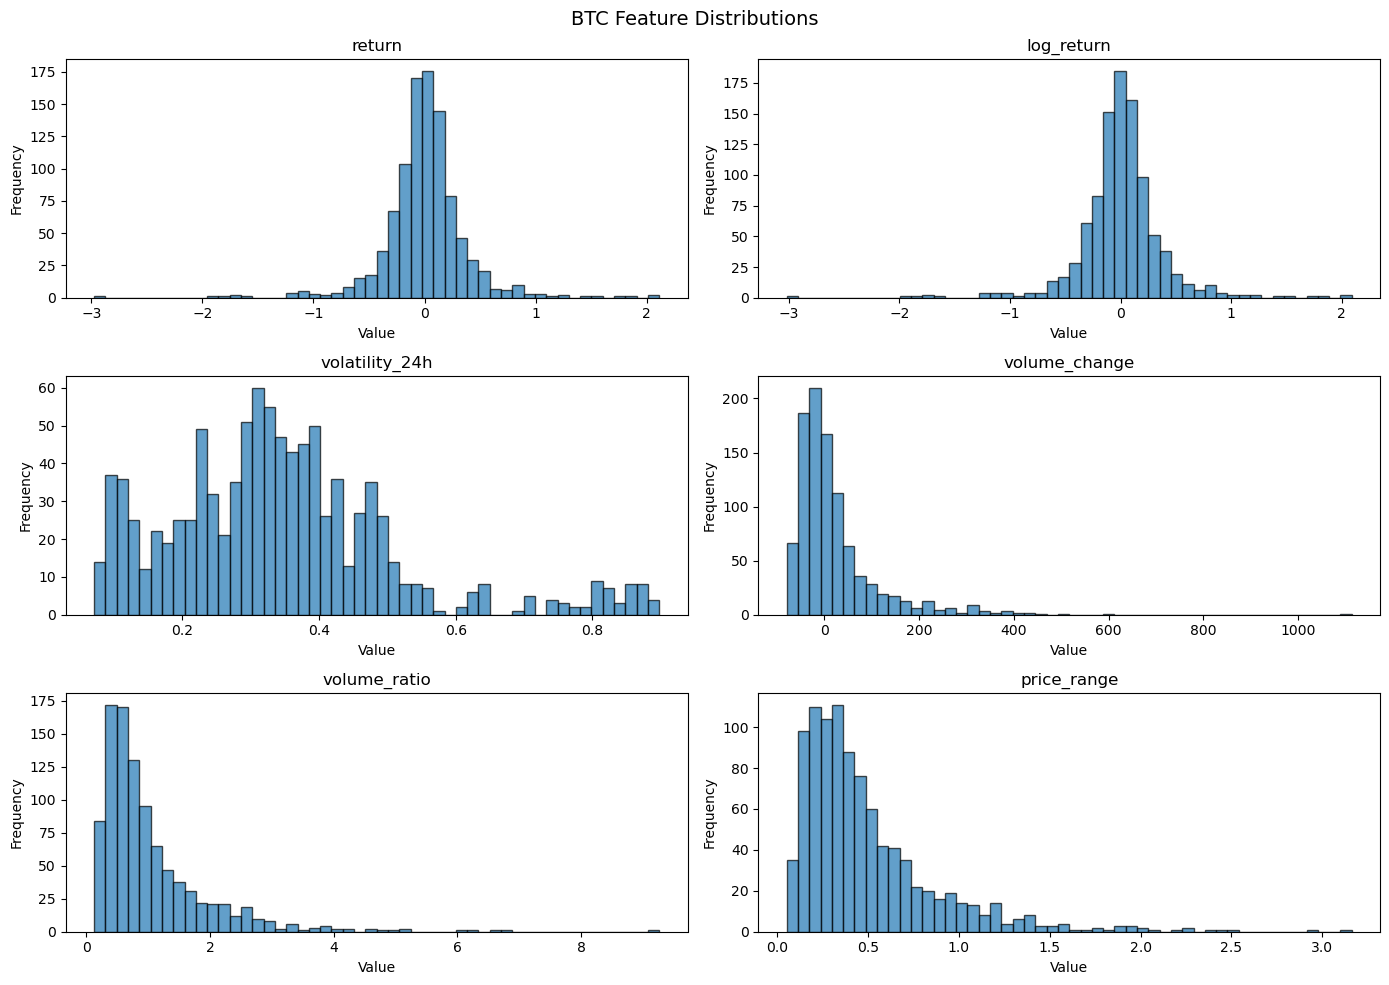

In [24]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle('BTC Feature Distributions', fontsize=14)

# Plot each feature
features_to_plot = ['return', 'log_return', 'volatility_24h', 
                    'volume_change', 'volume_ratio', 'price_range']

for idx, feature in enumerate(features_to_plot):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Histogram
    ax.hist(btc[feature], bins=50, edgecolor='black', alpha=0.7)
    ax.set_title(feature)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

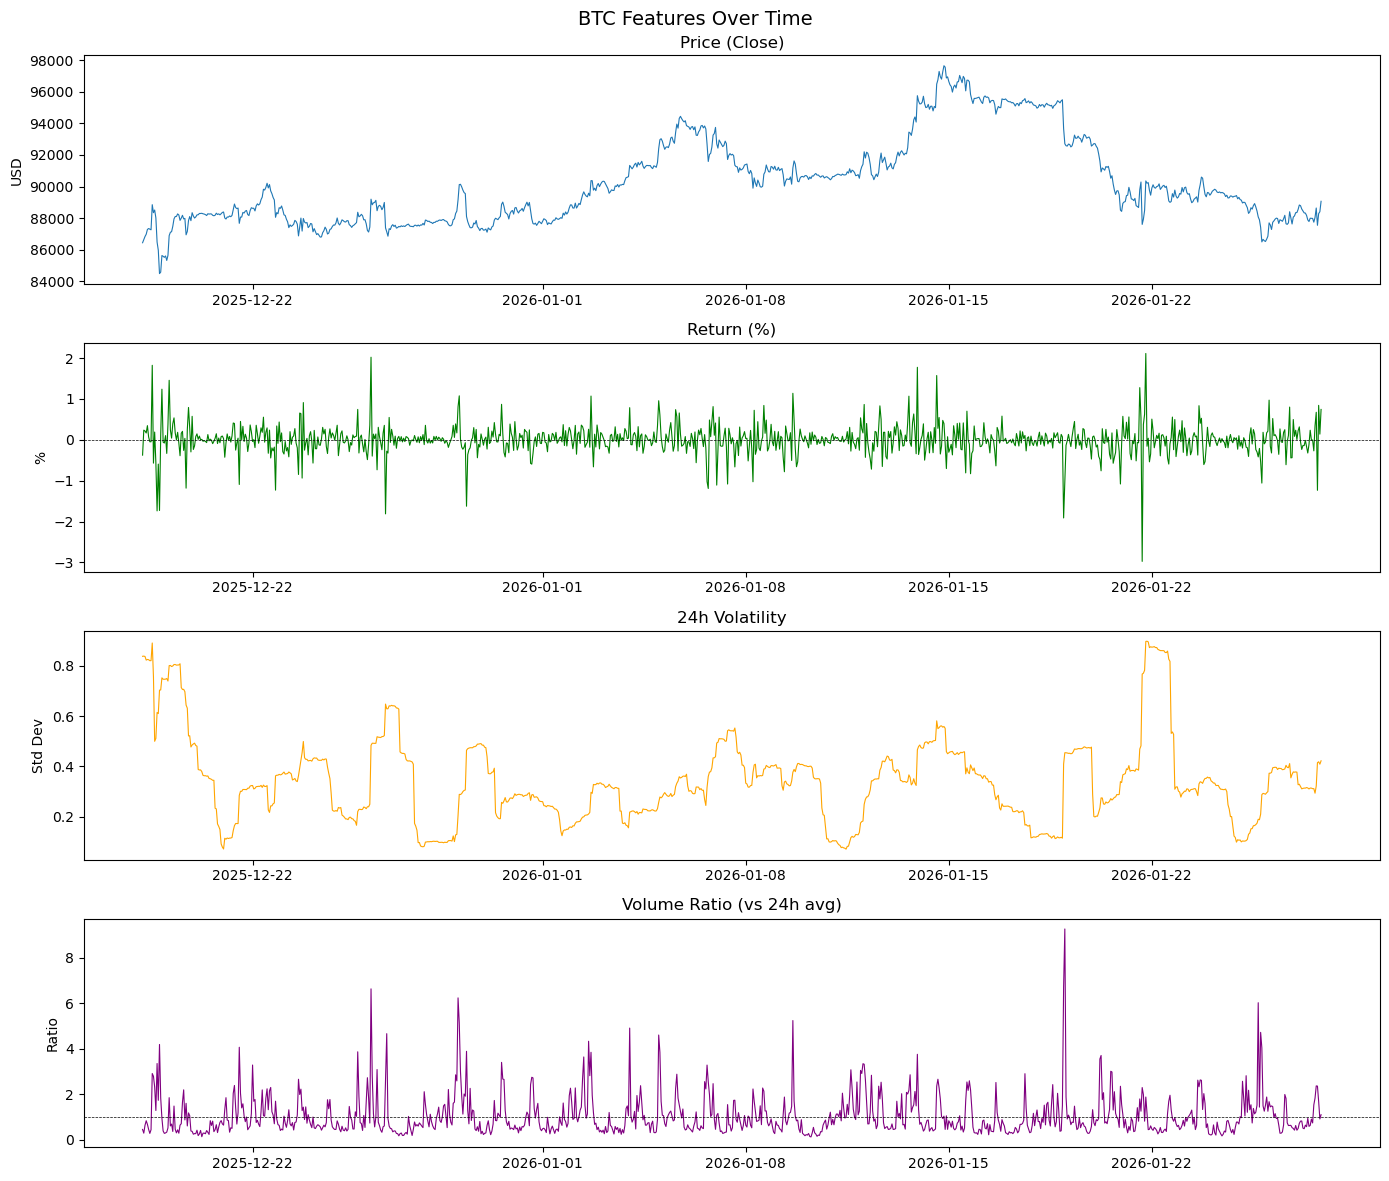

In [25]:
# Plot features over time
fig, axes = plt.subplots(4, 1, figsize=(14, 12))
fig.suptitle('BTC Features Over Time', fontsize=14)

# Price
axes[0].plot(btc['timestamp'], btc['close'], linewidth=0.8)
axes[0].set_title('Price (Close)')
axes[0].set_ylabel('USD')

# Return
axes[1].plot(btc['timestamp'], btc['return'], linewidth=0.8, color='green')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=0.5)
axes[1].set_title('Return (%)')
axes[1].set_ylabel('%')

# Volatility
axes[2].plot(btc['timestamp'], btc['volatility_24h'], linewidth=0.8, color='orange')
axes[2].set_title('24h Volatility')
axes[2].set_ylabel('Std Dev')

# Volume Ratio
axes[3].plot(btc['timestamp'], btc['volume_ratio'], linewidth=0.8, color='purple')
axes[3].axhline(y=1, color='black', linestyle='--', linewidth=0.5)
axes[3].set_title('Volume Ratio (vs 24h avg)')
axes[3].set_ylabel('Ratio')

plt.tight_layout()
plt.show()

## Step 8: Save Processed Data

Save our preprocessed data so we can use it in the next notebooks for ML models.

In [26]:
# ============================================
# SAVE PROCESSED DATA
# ============================================

# Save to CSV
btc.to_csv('../data/processed/BTCUSDT_1h_processed.csv', index=False)
eth.to_csv('../data/processed/ETHUSDT_1h_processed.csv', index=False)

print("Data saved!")
print(f"BTC: {len(btc)} rows, {len(btc.columns)} columns")
print(f"ETH: {len(eth)} rows, {len(eth.columns)} columns")

Data saved!
BTC: 976 rows, 12 columns
ETH: 976 rows, 12 columns


## Summary

### What we did:
1. **Loaded** CSV data into pandas DataFrames
2. **Checked** for missing values (none found)
3. **Converted** timestamp to proper datetime format
4. **Created 6 features:**
   - `return` - % price change
   - `log_return` - logarithmic return
   - `volatility_24h` - rolling standard deviation
   - `volume_change` - % volume change
   - `volume_ratio` - volume vs 24h average
   - `price_range` - high-low as % of price
5. **Dropped** rows with NaN values (first 24 rows)
6. **Saved** processed data

### Next steps:
- Implement anomaly detection models (Isolation Forest, One-Class SVM, LOF)
- Compare results across models

### Key terms to remember:
- **Preprocessing**: Cleaning and preparing raw data
- **Feature Engineering**: Creating new useful columns from existing data
- **Rolling window**: Calculating over a moving subset of data
- **NaN**: Missing value (Not a Number)